In [10]:
# Importing External Libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp


### Example ODE Solver

In [11]:
class ODESolver:
    # Superclass or class of classes
    # Meant to pass in many types of parameters and equations

    def __init__(self, f):
        self.f = f

    def advance(self):
        # advances solution one time step
        raise NotImplementedError
    
    def set_initial_conditions(self, U0):
        if isinstance(U0, (int, float)):
            # Scalar ODE
            self.number_of_equations = 1
            U0 = float(U0)
        else:
            # system of equations
            U0 = np.asarray(U0)
            self.number_of_equations = U0.size
        self.U0 = U0

    def solve(self, time_points):

        self.t = np.asarray(time_points)
        n = self.t.size

        self.u = np.zeros((n, self.number_of_equations))

        self.u[0, :] = self.U0

        # Integrate
        for i in range(n - 1):
            self.i = i
            self.u[i + 1] = self.advance()

        return self.u[:i+2], self.t[:i+2]
    
class ForwardEuler(ODESolver):
    # Inherits from above
    
    def advance(self):
        u, f, i, t = self.u, self.f, self.i, self.t
        dt = t[i + 1] - t[i]
        return u[i, :] + dt * f(u[i,:], t[i])

### SIR Model

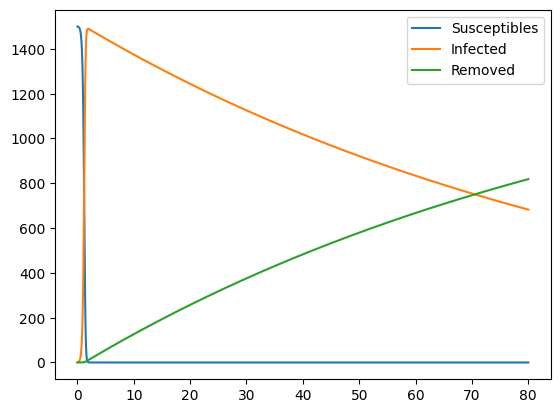

In [12]:
'''
SIR disease model

S' = -beta*S*I
I' = beta*S*I - nu*I
R' = nu*I
'''

class SIR():
    
    def __init__(self, nu, beta, S0, I0, R0):
        '''
        nu, beta: parameters in the ODE system
        S0, I0, R0: initial values
        '''

        if isinstance(nu, (float, int)):
            # Is number?
            self.nu = lambda t: nu
        elif callable(nu):
            self.nu = nu

        if isinstance(beta, (float, int)):
            # Is number?
            self.beta = lambda t: beta
        elif callable(beta):
            self.beta = beta
        
        self.initial_conditions = [S0, I0, R0]
    
    def __call__(self, u, t):
        S, I, R = u  # R is not really used
        return np.asarray([
            -self.beta(t)*S*I, # Susceptibles
            self.beta(t)*S*I - self.nu(t)*I, # Infectives
            self.nu(t)*I  # Removed
        ])

if __name__ == "__main__":

    nu = 0.01 # lambda t: 0.01 if t <= 5 else 0.005
    beta = lambda t: 0.005 if t <= 10 else 0.0001

    sir = SIR(nu, beta, 1500, 1, 0) # giving parameters to the model
    solver = ForwardEuler(sir) # giving the solver a problem to solve
    solver.set_initial_conditions(sir.initial_conditions)

    time_steps = np.linspace(0, 80, 1001) # Simulating 60 days
    u, t = solver.solve(time_steps)

    plt.plot(t, u[:, 0], label="Susceptibles")
    plt.plot(t, u[:, 1], label="Infected")
    plt.plot(t, u[:, 2], label="Removed")
    plt.legend()
    plt.show()


### More ODE Solvers for SIR

#### Pseudocode:

'''
SETUP FOR:
dS/dt = -(beta/total)*S*I
dI/dt = (beta/total)*S*I - Y*I
dR/dt = Y*I
'''

def dsdt(s, i, k):
    return -1*k*s*i

-  is beta/(total number of people)

def didt(s, i, k, g):
    return ((1*k*s*i)-(g*i))

- g is for gamma

def drdt(i, g):
    return g*i

s0 = 99
i0 = 1
k0 = 0.0005
g0 = 0.1


t = np.linspace(0, 60) # 60 days

In [13]:
# coupled systems

def dAdt(t, A):
    s, i, r = A
    dsdt = -beta*s*i
    didt = beta*s*i - gamma*i
    drdt = gamma*i
    return [dsdt, didt, drdt]

beta = 0.005
gamma = 0.01

s0 = 99
i0 = 1
r0 = 0
A_0 = [s0, i0, r0]

t = np.linspace(0, 60)

In [14]:
# Solutions

sol = odeint(dAdt, y0=A_0, t=t, tfirst=True)

s_Sol = sol.T[0]
i_Sol = sol.T[1]
r_Sol = sol.T[2]

s_Sol

array([9.90000000e+01, 9.81764152e+01, 9.67106189e+01, 9.41500947e+01,
       8.98197953e+01, 8.28825307e+01, 7.26778385e+01, 5.94036412e+01,
       4.46426521e+01, 3.08252387e+01, 1.98132302e+01, 1.20957962e+01,
       7.15107042e+00, 4.15505130e+00, 2.39609826e+00, 1.37963196e+00,
       7.95936507e-01, 4.61018250e-01, 2.68389086e-01, 1.57137431e-01,
       9.25544510e-02, 5.48505316e-02, 3.27078856e-02, 1.96250708e-02,
       1.18479416e-02, 7.19657513e-03, 4.39778770e-03, 2.70358452e-03,
       1.67191279e-03, 1.03998131e-03, 6.50645670e-04, 4.09394408e-04,
       2.59052052e-04, 1.64835649e-04, 1.05464061e-04, 6.78450305e-05,
       4.38792147e-05, 2.85315907e-05, 1.86489385e-05, 1.22525319e-05,
       8.09159249e-06, 5.36910640e-06, 3.58098962e-06, 2.40073666e-06,
       1.61698010e-06, 1.09420466e-06, 7.44747048e-07, 5.09264398e-07,
       3.49612381e-07, 2.41230843e-07])

### Plotting new ODE model of SIR

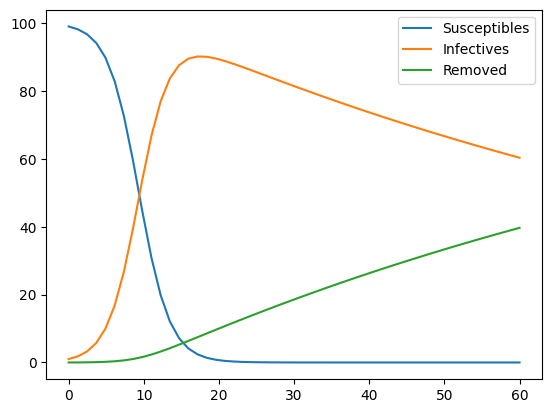

In [15]:
plt.plot(t, s_Sol, label = "Susceptibles")
plt.plot(t, i_Sol, label = "Infectives")
plt.plot(t, r_Sol, label = "Removed")
plt.legend()
plt.show()

### Messing with code to visualize it as moving people

In [16]:
import folium
import numpy as np
import time

# Create a base map
map_center = [40.7128, -74.0060]  # Centered on New York City
map_model = folium.Map(location=map_center, zoom_start=12)

# Number of people
num_people = 100

# Randomly generate coordinates for people
latitudes = np.random.uniform(low=40.70, high=40.75, size=num_people)
longitudes = np.random.uniform(low=-74.02, high=-73.98, size=num_people)

# Function to update map with new positions
def update_map(latitudes, longitudes, step):
    map_model = folium.Map(location=map_center, zoom_start=12)
    for lat, lon in zip(latitudes, longitudes):
        folium.CircleMarker(location=[lat, lon], radius=3, color='blue').add_to(map_model)
    map_model.save(f'map_model_step_{step}.html')

# Animate changes over time
num_steps = 10
delta = 0.001  # Change in coordinates per step
for step in range(num_steps):
    # Update positions
    latitudes += np.random.uniform(low=-delta, high=delta, size=num_people)
    longitudes += np.random.uniform(low=-delta, high=delta, size=num_people)
    # Update map
    update_map(latitudes, longitudes, step)
    time.sleep(1)  # Pause to simulate time passing

# Note: This example saves each step as an HTML file.
# To view the animation, open the saved HTML files in sequence.


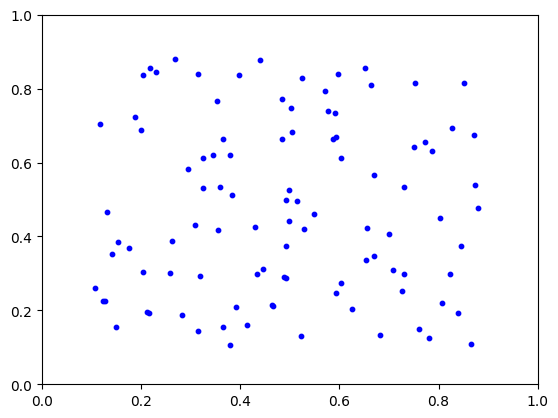

In [17]:
import random

# Define the coordinates for the dot
x = np.random.uniform(low=0.1, high=0.9, size=100)
y = np.random.uniform(low=0.1, high=0.9, size=100)

# Create a new figure
plt.figure()

# chance of turning red (infectious)
outcomes = ['blue', 'red']
probabilities = [0.9, 0.1]

# Plot the dot using scatter
plt.scatter(x, y, s=10, color= random.choices(outcomes, probabilities))  # s=100 sets the size of the dot

# Set the limits of the axes
plt.xlim(0, 1)
plt.ylim(0, 1)

# Display the plot
plt.show()


In [18]:
# Model spatial dynamics of a small town